# 0. Import packages

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [ ]:
# %cd "/content/gdrive/MyDrive/LDS0_K273_DamThiMinhPhuong/Project"

In [ ]:
# !pip3 install pandas_profiling --upgrade
# !pip install squarify
# !pip install plotly
# !pip install pyyaml==5.4.1
# !pip install import_ipynb

In [1]:
import numpy as np
import pandas as pd
from numpy import where
from numpy import unique
import matplotlib.pyplot as plt
import pandas_profiling as pp
import seaborn as sb
import plotly.express as px
import squarify
from datetime import datetime
import collections
from collections import Counter
import import_ipynb
import Lib
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from Lib.ipynb


In [2]:
from pyclustertend import hopkins
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn import metrics


from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

# 1. Load data

In [3]:
df = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape')

In [4]:
df.shape

(541909, 8)

In [5]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# 2. EDA

In [7]:
# rows which contain 'C' in InvoiceNo
df[df['InvoiceNo'].str.contains('C', na=False)].head()

InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

          InvoiceDate  UnitPrice  CustomerID         Country  
141  01-12-2010 09:41      27.50     14527.0  United Kingdom  
154  01-12-2010 09:49       4.65     15311.0  United Kingdom  
235  01-12-2010 10:24       1.65     17548.0  United Kingdom  
236  01-12-2010 10:24       0.29     17548.0  United Kingdom  
237  01-12-2010 10:24       0.29     17548.0  United Kingdom

In [8]:
df[df["InvoiceNo"].str.contains("C", na=False)].describe()

Quantity     UnitPrice    CustomerID
count   9288.000000   9288.000000   8905.000000
mean     -29.885228     48.393661  14991.667266
std     1145.786965    666.600430   1706.772357
min   -80995.000000      0.010000  12346.000000
25%       -6.000000      1.450000  13510.000000
50%       -2.000000      2.950000  14895.000000
75%       -1.000000      5.950000  16393.000000
max       -1.000000  38970.000000  18282.000000

Comment: rows where 'InvoiceNo' contains 'C' have 'Quantity' < 0

In [9]:
# rows which contain 'A' in InvoiceNo
df[df['InvoiceNo'].str.contains('A', na=False)]

InvoiceNo StockCode      Description  Quantity       InvoiceDate  \
299982   A563185         B  Adjust bad debt         1  12-08-2011 14:50   
299983   A563186         B  Adjust bad debt         1  12-08-2011 14:51   
299984   A563187         B  Adjust bad debt         1  12-08-2011 14:52   

        UnitPrice  CustomerID         Country  
299982   11062.06         NaN  United Kingdom  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

Comment:rows where 'InvoiceNo' contains 'A' have CustomerID == NaN

In [10]:
# drop rows where Quantity < 0
print(df[df.Quantity < 0].shape[0])
df = df[df.Quantity >= 0]
df.shape

10624


(531285, 8)

In [11]:
# drop rows where CustomerID == null
df = df[df.CustomerID.notnull()]
df.shape

(397924, 8)

In [12]:
# drop rows where UnitPrice < 0
print(df[df.UnitPrice < 0].shape[0])
df = df[df.UnitPrice >= 0]
df.shape

0


(397924, 8)

In [13]:
df.isnull().any()

InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID     False
Country        False
dtype: bool

Comment: There are no more nulls in the data set



In [14]:
# Check & drop duplicated rows
print(df.duplicated().sum())
df = df.drop_duplicates()
df.shape

5192


(392732, 8)

In [15]:
# Convert column 'InvoiceDate' to datetime datatype
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [16]:
# convert InvoiceNo data type to integer
df.InvoiceNo = df.InvoiceNo.astype(int)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  int64         
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  float64       
 7   Country      392732 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 27.0+ MB


In [18]:
# Let’s take a closer look at the data we will need to manipulate.
print('Transactions timeframe from {} to {}'.format(df['InvoiceDate'].min(), df['InvoiceDate'].max()))
print('{:,} transactions don\'t have a customer id'.format(df[df.CustomerID.isnull()].shape[0]))
print('{:,} unique customer_id'.format(len(df.CustomerID.unique())))

Transactions timeframe from 2010-01-12 08:26:00 to 2011-12-10 17:19:00
0 transactions don't have a customer id
4,339 unique customer_id


In [19]:
# pp.ProfileReport(df)

In [20]:
df.describe()

InvoiceNo       Quantity      UnitPrice     CustomerID
count  392732.000000  392732.000000  392732.000000  392732.000000
mean   560591.072436      13.153718       3.125596   15287.734822
std     13087.116747     181.588420      22.240725    1713.567773
min    536365.000000       1.000000       0.000000   12346.000000
25%    549234.000000       2.000000       1.250000   13955.000000
50%    561874.000000       6.000000       1.950000   15150.000000
75%    572061.000000      12.000000       3.750000   16791.000000
max    581587.000000   80995.000000    8142.750000   18287.000000

# 3. Clustering

### 3.1 RFM

In [21]:
# Create new column 'Amount'
df['Amount'] = df['Quantity'] * df['UnitPrice']
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Amount  
0 2010-01-12 08:26:00       2.55     17850.0  United Kingdom   15.30  
1 2010-01-12 08:26:00       3.39     17850.0  United Kingdom   20.34  
2 2010-01-12 08:26:00       2.75     17850.0  United Kingdom   22.00  
3 2010-01-12 08:26:00       3.39     17850.0  United Kingdom   20.34  
4 2010-01-12 08:26:00       3.39     17850.0  United Kingdom   20.34

In [22]:
# Get max date of dataframe
max_date = df['InvoiceDate'].max().date()

# Calculate R, F, M
Recency = lambda x: (max_date - x.max().date()).days
Frequency = lambda x: x.nunique()
Monetary = lambda x: round(sum(x),2)

df_RFM = df.groupby('CustomerID').agg({'InvoiceDate' : Recency,
                                        'InvoiceNo' : Frequency,
                                        'Amount' : Monetary,
                                        })

In [23]:
df_RFM.head()

InvoiceDate  InvoiceNo    Amount
CustomerID                                  
12346.0             326          1  77183.60
12347.0              40          7   4310.00
12348.0              76          4   1797.24
12349.0              19          1   1757.55
12350.0             311          1    334.40

In [24]:
# Rename column names
df_RFM.columns = ['Recency', 'Frequency', 'Monetary']

# Descending Sorting 
df_RFM = df_RFM.sort_values('Monetary', ascending=False)

In [25]:
df_RFM.head(5)

Recency  Frequency   Monetary
CustomerID                               
14646.0           2         74  280206.02
18102.0          12         60  259657.30
17450.0           3         46  194390.79
16446.0          89          2  168472.50
14911.0           0        201  143711.17

In [26]:
df_RFM.shape

(4339, 3)

In [27]:
df_RFM.describe()

Recency    Frequency       Monetary
count  4339.000000  4339.000000    4339.000000
mean    105.461858     4.271952    2048.215923
std     115.083263     7.705493    8984.248352
min       0.000000     1.000000       0.000000
25%      22.000000     1.000000     306.455000
50%      61.000000     2.000000     668.560000
75%     161.500000     5.000000    1660.315000
max     697.000000   210.000000  280206.020000

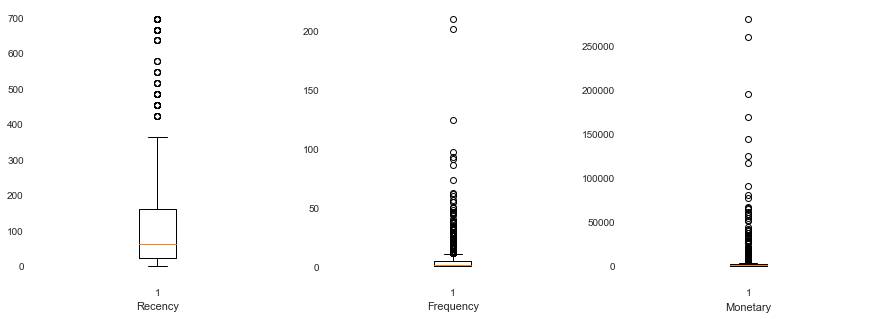

In [28]:
### Visualization
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.boxplot(df_RFM['Recency'])
plt.xlabel('Recency')
plt.subplot(1, 3, 2)
plt.boxplot(df_RFM['Frequency'])
plt.xlabel('Frequency')
plt.subplot(1, 3, 3)
plt.boxplot(df_RFM['Monetary'])
plt.xlabel('Monetary')
plt.show()

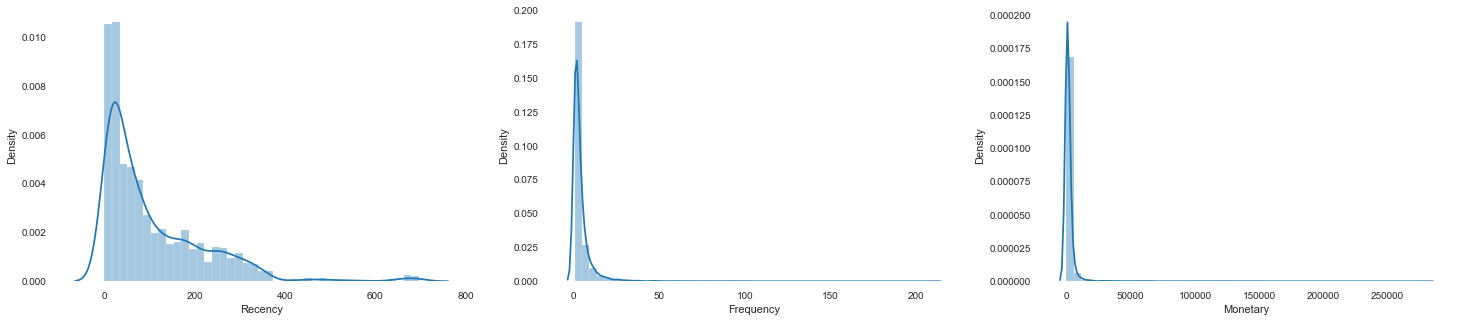

In [29]:
### Visualization
plt.figure(figsize=(25,5))
plt.subplot(1, 3, 1)
sb.distplot(df_RFM['Recency'])
plt.subplot(1, 3, 2)
sb.distplot(df_RFM['Frequency'])
plt.subplot(1, 3, 3)
sb.distplot(df_RFM['Monetary'])
plt.show()

Comment:
- All three of them have ouliters
- All three of them have right-skewed distribution

In [30]:
# Create labels for Recency, Frequency, Monetary
r_label = range(4, 0, -1)
f_label = range(1, 5)
m_label = range(1, 5)

r_group = pd.qcut(df_RFM['Recency'].rank(method = 'first'), q = 4, labels = r_label)
f_group = pd.qcut(df_RFM['Frequency'].rank(method = 'first'), q = 4, labels = f_label)
m_group = pd.qcut(df_RFM['Monetary'].rank(method = 'first'), q = 4, labels = m_label)

In [31]:
# Create new columns R, F, M
df_RFM = df_RFM.assign(R=r_group, F=f_group, M=m_group)
df_RFM.head()

Recency  Frequency   Monetary  R  F  M
CustomerID                                        
14646.0           2         74  280206.02  4  4  4
18102.0          12         60  259657.30  4  4  4
17450.0           3         46  194390.79  4  4  4
16446.0          89          2  168472.50  2  2  4
14911.0           0        201  143711.17  4  4  4

In [32]:
# Calculate RFM Score
df_RFM['RFM_score'] = (df_RFM.R.astype(str) + df_RFM.F.astype(str) + df_RFM.M.astype(str)).astype(int)
df_RFM.head()

Recency  Frequency   Monetary  R  F  M  RFM_score
CustomerID                                                   
14646.0           2         74  280206.02  4  4  4        444
18102.0          12         60  259657.30  4  4  4        444
17450.0           3         46  194390.79  4  4  4        444
16446.0          89          2  168472.50  2  2  4        224
14911.0           0        201  143711.17  4  4  4        444

In [33]:
df_RFM.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4339 entries, 14646.0 to 13256.0
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Recency    4339 non-null   int64   
 1   Frequency  4339 non-null   int64   
 2   Monetary   4339 non-null   float64 
 3   R          4339 non-null   category
 4   F          4339 non-null   category
 5   M          4339 non-null   category
 6   RFM_score  4339 non-null   int64   
dtypes: category(3), float64(1), int64(3)
memory usage: 182.6 KB


In [34]:
def customer_level(df):
    if (df['R'] == 4 and df['F'] == 4 and df['M'] == 4):
        return 'VIP'
    elif (df['R'] == 4 and (df['F'] == 1 or df['F'] == 2) and df['M'] <= 2):
        return 'NEW'
    elif (df['F'] == 4 and df['M'] <= 3 ):
        return 'POTENTIAL'
    else:
        if df['R'] == 1:
            return 'LOST'
        elif df['F'] == 4:
            return 'LOYAL'
    return 'REGULARS'

In [35]:
df_RFM['level'] = df_RFM.apply(customer_level, axis = 1)
df_RFM.head()

Recency  Frequency   Monetary  R  F  M  RFM_score     level
CustomerID                                                             
14646.0           2         74  280206.02  4  4  4        444       VIP
18102.0          12         60  259657.30  4  4  4        444       VIP
17450.0           3         46  194390.79  4  4  4        444       VIP
16446.0          89          2  168472.50  2  2  4        224  REGULARS
14911.0           0        201  143711.17  4  4  4        444       VIP

In [36]:
df_RFM['level'].value_counts()

REGULARS     2009
LOST         1076
VIP           445
LOYAL         346
POTENTIAL     281
NEW           182
Name: level, dtype: int64

In [37]:
df_RFM['level'].value_counts()

REGULARS     2009
LOST         1076
VIP           445
LOYAL         346
POTENTIAL     281
NEW           182
Name: level, dtype: int64

In [38]:
rfm_agg = df_RFM.groupby('level').agg({'Recency': 'mean',
                                       'Frequency': 'mean',
                                       'Monetary': ['mean', 'count']}).round(0)
rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['mean_recent', 'mean_freq', 'mean_money', 'count']
rfm_agg['Percentage'] = round((rfm_agg['count'] / rfm_agg['count'].sum()) *100, 2)
rfm_agg = rfm_agg.reset_index()

rfm_agg

level  mean_recent  mean_freq  mean_money  count  Percentage
0       LOST        270.0        2.0       572.0   1076       24.80
1      LOYAL         53.0       10.0      5204.0    346        7.97
2        NEW         13.0        1.0       340.0    182        4.19
3  POTENTIAL         45.0        6.0      1146.0    281        6.48
4   REGULARS         64.0        2.0      1016.0   2009       46.30
5        VIP         10.0       16.0      9094.0    445       10.26

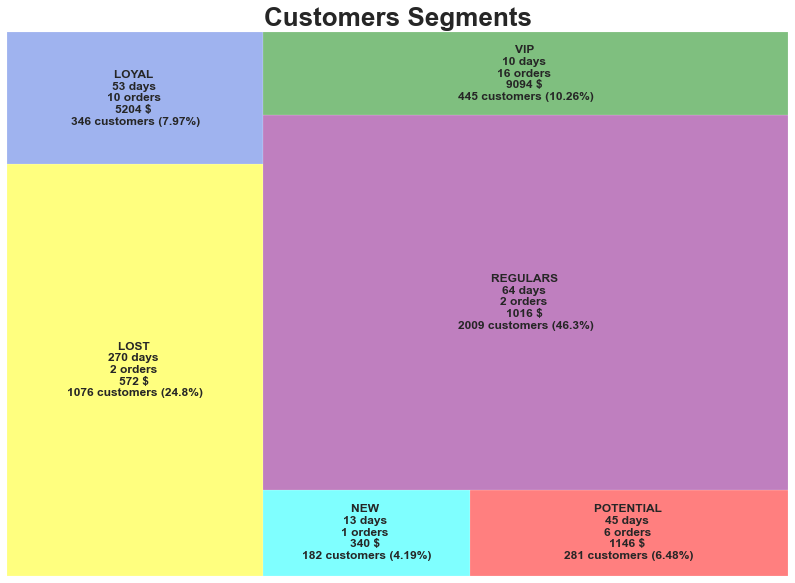

In [39]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'VIP':'yellow','NEW':'royalblue', 'REGULARS':'cyan',
               'LOST':'red', 'LOYAL':'purple', 'POTENTIAL':'green'}

squarify.plot(sizes=rfm_agg['count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('RFM Segments.png')
plt.show()

In [40]:
fig = px.scatter(rfm_agg, x='mean_recent', y="mean_money", size='mean_freq', color="level",
           hover_name="level", size_max=100)
fig.show()

In [41]:
fig = px.scatter_3d(df_RFM, x='Recency', y='Frequency', z='Monetary',
                    color = 'level', opacity=0.5,
                    color_discrete_map = colors_dict)
fig.update_traces(marker=dict(size=5),
                  
                  selector=dict(mode='markers'))
fig.show()

# 4. Clustering with ML algorithms in original data:

## 4.1 Hopkins Statistic:

In [42]:
df_rfm = df_RFM[['Recency', 'Frequency', 'Monetary']]
df_rfm.head()

Recency  Frequency   Monetary
CustomerID                               
14646.0           2         74  280206.02
18102.0          12         60  259657.30
17450.0           3         46  194390.79
16446.0          89          2  168472.50
14911.0           0        201  143711.17

In [43]:
scaler = RobustScaler()
df_scaled = scaler.fit_transform(df_rfm)

In [44]:
hopkins(df_scaled, df_scaled.shape[0])

0.00817335312284007

## 4.2 KMeans

In [143]:
kmeans_per_k = [KMeans(n_clusters = k, random_state = 42).fit(df_scaled) for k in range(1, 15)]
inertias = [model.inertia_ for model in kmeans_per_k]

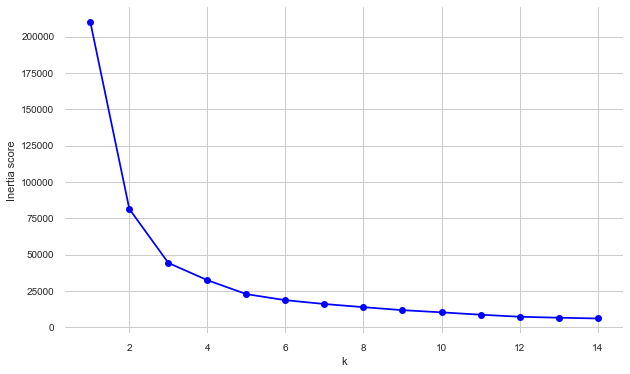

In [144]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), inertias, '-bo')
plt.xlabel('k')
plt.ylabel('Inertia score')
plt.grid(True);

- Biểu đồ điểm số `inertia` và số cụm k cho thấy khá khó để xác định elbow, chỉ số inertia giảm rất nhanh khi k tiến đến 3 và giảm đều từ k = 4.


- Ta sẽ sử dụng chỉ số `silhouette` để xác định sự phân bổ của các mẫu trong từng cụm: 

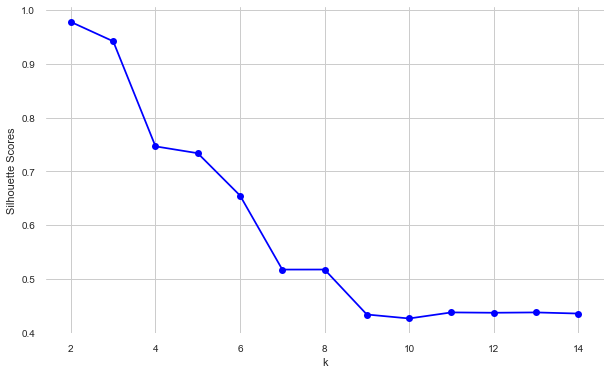

In [145]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(df_scaled, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), silhouette_scores, '-bo')
plt.xlabel('k')
plt.ylabel('Silhouette Scores')
plt.grid(True);

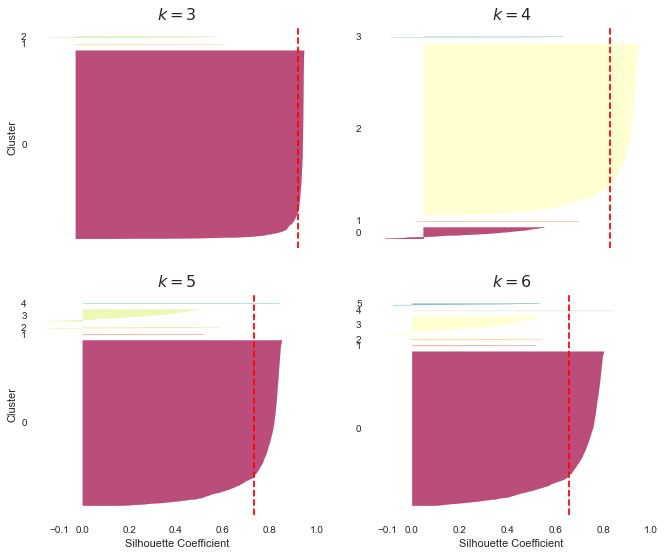

In [48]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(df_scaled, y_pred)

    padding = len(df_rfm) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.savefig("silhouette_analysis_plot")
plt.show()

- Kết quả khá tệ, đối với cả 4 mức k, gần như các mẫu đều có hệ số thấp hơn điểm số `silhouette` của chính cụm đó (gần một nửa số mẫu đều không vượt qua ranh giới cụm).


- Từ biểu đồ có thể thấy các cụm không tách biệt nhau hoàn toàn, mẫu của một cụm nằm khá gần các cụm khác. Ta sẽ thấy rõ hơn điều này bằng biểu đồ phía dưới đối với cả 3 thuộc tính.

In [49]:
df_kmean = df_rfm.copy()
df_kmean.head()

Recency  Frequency   Monetary
CustomerID                               
14646.0           2         74  280206.02
18102.0          12         60  259657.30
17450.0           3         46  194390.79
16446.0          89          2  168472.50
14911.0           0        201  143711.17

In [50]:
kmean_model = KMeans(n_clusters = 4, random_state = 42)
kmean_model.fit(df_scaled)
kmean_model.labels_.shape

(4339,)

In [51]:
df_kmean['cluster'] = kmean_model.labels_

df_kmean.groupby('cluster').agg({'Recency': 'mean',
                               'Frequency': 'mean',
                               'Monetary': ['mean', 'count']}).round(2)

kmean_agg = df_kmean.groupby('cluster').agg({'Recency': 'mean',
                                           'Frequency': 'mean',
                                           'Monetary': ['mean', 'count']}).round(0)

kmean_agg.columns = kmean_agg.columns.droplevel()
kmean_agg.columns = ['mean_recent', 'mean_freq', 'mean_money', 'count']
kmean_agg['percentage'] = round((kmean_agg['count'] / kmean_agg['count'].sum()) * 100, 2)
kmean_agg = kmean_agg.reset_index()
kmean_agg['cluster'] = 'cluster' + kmean_agg['cluster'].astype(str)
kmean_agg

cluster  mean_recent  mean_freq  mean_money  count  percentage
0  cluster0        111.0        3.0       993.0   4042       93.16
1  cluster1         21.0       77.0    209288.0      5        0.12
2  cluster2         31.0       50.0     60341.0     23        0.53
3  cluster3         25.0       18.0      9075.0    269        6.20

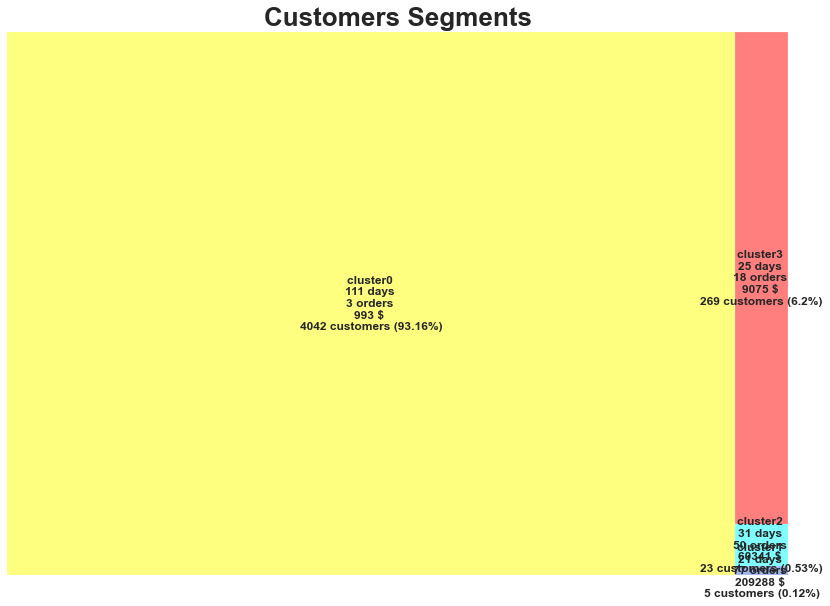

In [52]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=kmean_agg['count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*kmean_agg.iloc[i])
                      for i in range(0, len(kmean_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('Unsupervised Segments.png')
plt.show()

In [53]:
fig = px.scatter(kmean_agg, x='mean_recent', y='mean_freq', size='mean_money', color="cluster",
           hover_name="cluster", size_max=100)
fig.show()

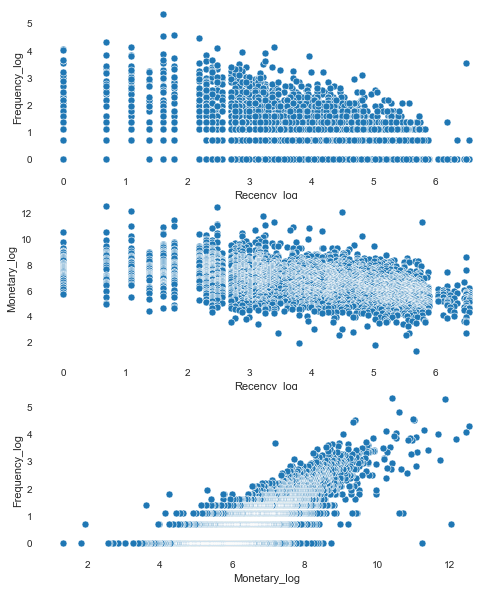

In [54]:
demo = df_rfm.copy()
for col in demo.columns:
    demo[col + '_log'] = np.log(demo[col])
    
plt.figure(figsize=(8,10))
plt.subplot(3, 1, 1)
sb.scatterplot(data = demo, x = 'Recency_log', y = 'Frequency_log')
plt.subplot(3, 1, 2)
sb.scatterplot(data = demo, x = 'Recency_log', y = 'Monetary_log');
plt.subplot(3, 1, 3)
sb.scatterplot(data = demo, x = 'Monetary_log', y = 'Frequency_log');
plt.show()

- Biểu đồ trên phần nào minh chứng cho hạn chế của thuật toán `KMeans`, hình dạng các cụm dữ liệu có kích thước khác biệt nhau, có hình dạng phi cầu và mật độ dữ liệu khá khác biệt.


- Các đặc điểm trên của dữ liệu khiến cho thuật toán `KMeans` hoạt động không được tốt. Ta sẽ thử phân cụm dữ liệu với các thuật toán khác cho phép phân cụm với hình dạng và kích thước bất kỳ (bằng cách điều chỉnh hyperparameters).


- Bắt đầu với `Gaussian Mixture`.

## 4.3 Gaussian Mixture

In [146]:
from sklearn.mixture import GaussianMixture

gm_per_k = [GaussianMixture(n_components = k, n_init = 10, random_state = 42).fit(df_scaled)
           for k in range(2, 15)]
silhouette_scores = [silhouette_score(df_scaled, model.predict(df_scaled)) for model in gm_per_k[1:]]

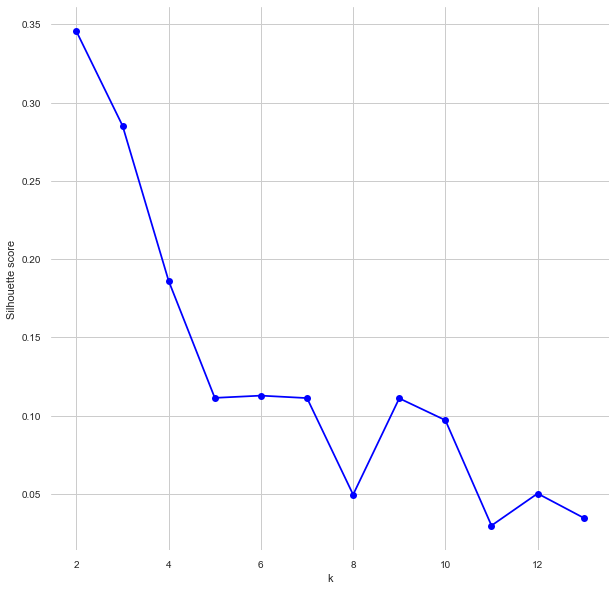

In [148]:
plt.figure(figsize=(10, 10))
plt.plot(range(2, 14), silhouette_scores, '-bo')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.grid(True);

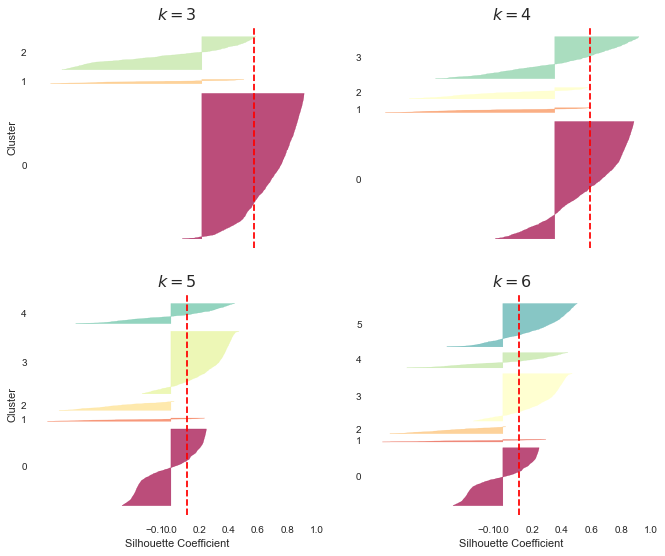

In [57]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = gm_per_k[k - 1].predict(df_scaled)
    silhouette_coefficients = silhouette_samples(df_scaled, y_pred)

    padding = len(df_rfm) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.savefig("silhouette_analysis_plot")
plt.show()

In [58]:
bics = [model.bic(df_scaled) for model in gm_per_k]
aics = [model.aic(df_scaled) for model in gm_per_k]

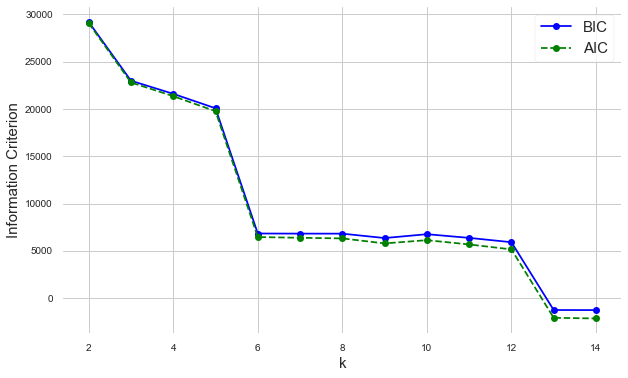

In [59]:
plt.figure(figsize = (10, 6))
plt.plot(range(2, 15), bics, 'bo-', label = 'BIC')
plt.plot(range(2, 15), aics, 'go--', label = 'AIC')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Information Criterion', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid(True);

In [60]:
for model in gm_per_k:
    print('Iter: {} - Converged: {}'.format(model.n_iter_, model.converged_))

Iter: 11 - Converged: True
Iter: 23 - Converged: True
Iter: 26 - Converged: True
Iter: 41 - Converged: True
Iter: 47 - Converged: True
Iter: 44 - Converged: True
Iter: 53 - Converged: True
Iter: 64 - Converged: True
Iter: 43 - Converged: True
Iter: 45 - Converged: True
Iter: 47 - Converged: True
Iter: 56 - Converged: True
Iter: 53 - Converged: True


- Cả BIC và AIC đều cho thấy lựa chọn tốt nhất là 4, điểm số của các cụm > 4 đều < 0.

In [61]:
df_gm = df_rfm.copy()
df_gm.head()

Recency  Frequency   Monetary
CustomerID                               
14646.0           2         74  280206.02
18102.0          12         60  259657.30
17450.0           3         46  194390.79
16446.0          89          2  168472.50
14911.0           0        201  143711.17

In [62]:
gm_model = GaussianMixture(n_components = 4, n_init = 10, random_state = 42)
gm_model.fit(df_scaled)

GaussianMixture(n_components=4, n_init=10, random_state=42)

In [63]:
gm_model.weights_

array([0.48439086, 0.01699103, 0.11932687, 0.37929123])

In [64]:
gm_model.means_

array([[ 0.73857497, -0.14021232, -0.22359837],
       [-0.3380209 ,  9.59302001, 30.35933541],
       [ 0.18830785,  1.91682042,  3.12558374],
       [-0.14701853,  0.64378528,  0.62896298]])

In [65]:
gm_model.covariances_

array([[[ 8.75747039e-01, -3.07719604e-02, -2.07459843e-02],
        [-3.07719604e-02,  2.45739134e-02,  1.39344517e-02],
        [-2.07459843e-02,  1.39344517e-02,  2.98985467e-02]],

       [[ 1.24278185e-02, -3.52160813e-01,  5.49186864e-01],
        [-3.52160813e-01,  8.02824803e+01,  8.57244381e+01],
        [ 5.49186864e-01,  8.57244381e+01,  1.55292827e+03]],

       [[ 4.86379627e-01, -6.83069840e-01, -7.11271794e-01],
        [-6.83069840e-01,  2.87868249e+00,  2.10492166e+00],
        [-7.11271794e-01,  2.10492166e+00,  1.23678288e+01]],

       [[ 5.52280699e-02, -3.46088390e-02, -2.27536485e-02],
        [-3.46088390e-02,  3.80733204e-01,  2.70790051e-01],
        [-2.27536485e-02,  2.70790051e-01,  4.97114588e-01]]])

In [66]:
gm_cluster = gm_model.predict(df_scaled)
gm_cluster

array([1, 1, 1, ..., 0, 0, 0])

In [67]:
df_gm['cluster'] = gm_cluster

df_gm.groupby('cluster').agg({'Recency': 'mean',
                               'Frequency': 'mean',
                               'Monetary': ['mean', 'count']}).round(2)

gm_agg = df_gm.groupby('cluster').agg({'Recency': 'mean',
                                       'Frequency': 'mean',
                                       'Monetary': ['mean', 'count']}).round(0)

gm_agg.columns = gm_agg.columns.droplevel()
gm_agg.columns = ['mean_recent', 'mean_freq', 'mean_money', 'count']
gm_agg['percentage'] = round((gm_agg['count'] / gm_agg['count'].sum()) * 100, 2)
gm_agg = gm_agg.reset_index()
gm_agg['cluster'] = 'cluster' + gm_agg['cluster'].astype(str)

gm_agg

cluster  mean_recent  mean_freq  mean_money  count  percentage
0  cluster0        160.0        1.0       355.0   2175       50.13
1  cluster1         13.0       44.0     46202.0     65        1.50
2  cluster2         88.0       10.0      5168.0    495       11.41
3  cluster3         40.0        5.0      1592.0   1604       36.97

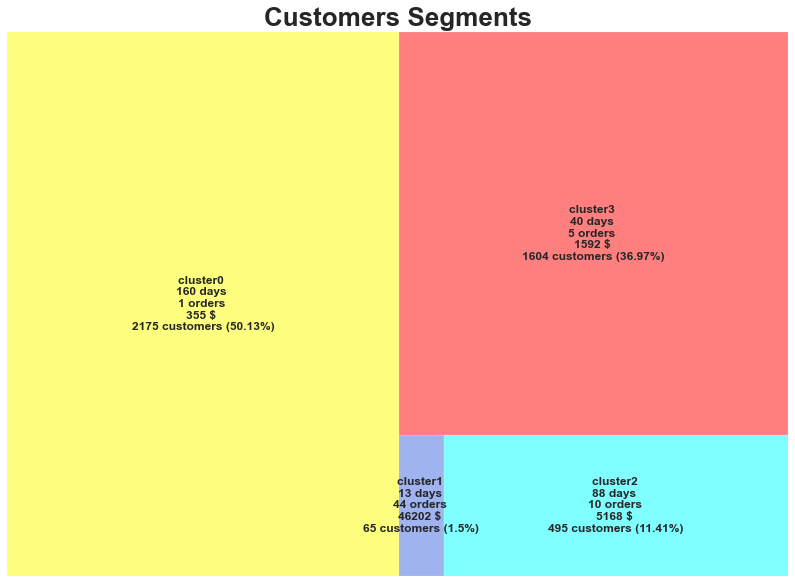

In [68]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=gm_agg['count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*gm_agg.iloc[i])
                      for i in range(0, len(gm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.savefig('GMM_k4.png')
plt.show()

In [69]:
fig = px.scatter(gm_agg, x='mean_recent', y='mean_freq', size='mean_money', color="cluster",
           hover_name="cluster", size_max=100)
fig.show()

## 4.4 Bayes Gaussian Mixture

In [70]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components = 8, n_init = 10)
bgm.fit(df_scaled)
np.round(bgm.weights_, 2)

array([0.39, 0.01, 0.13, 0.04, 0.01, 0.13, 0.26, 0.04])

- Lớp `BayesGaussian` có đặc điểm là sẽ gán trọng số gần bằng không (hoặc 0) cho các cụm không cần thiết, ta giả sử cần chia 7 cụm như phía trên và thuật toán chỉ ra chỉ có 4 cụm là cần thiết, 3 cụm có trọng số gần bằng 0 và 1 cụm có trọng số bằng 0.


- Ta sẽ giảm số cụm giả định xuống và kiểm tra thủ công số cụm tối ưu:

In [71]:
bgm = BayesianGaussianMixture(n_components = 3, n_init = 10)
bgm.fit(df_scaled)
np.round(bgm.weights_, 2)

array([0.59, 0.36, 0.05])

- Thuật toán vẫn cho thấy chỉ có 2 cụm có trọng số đáng kể,  cụm còn lại có trọng số gần bằng 0.

- Với các kiểm định trên, ta sẽ xác định số cụm tối ưu cho bài toán này là k = 2 và thử lần lượt với các thuật toán đã kể trên.

In [72]:
bgm_per_k = [BayesianGaussianMixture(n_components = k, n_init = 10, random_state = 42).fit(df_scaled)
             for k in range(2, 15)]
silhouette_scores = [silhouette_score(df_scaled, model.predict(df_scaled)) for model in bgm_per_k[1:]]

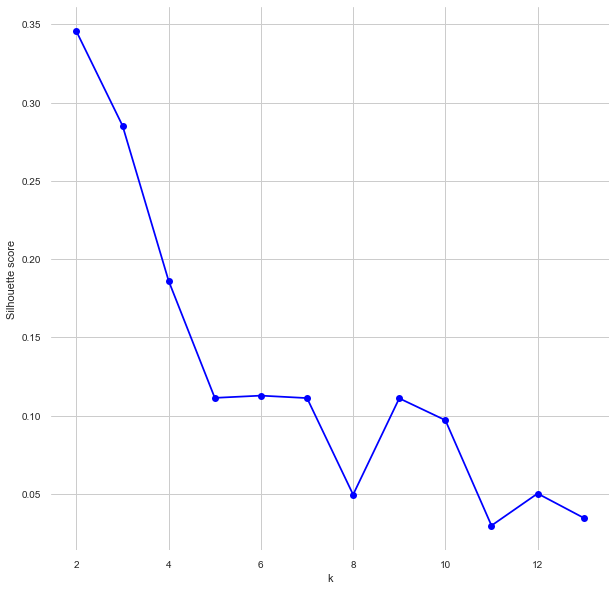

In [150]:
plt.figure(figsize=(10, 10))
plt.plot(range(2, 14), silhouette_scores, '-bo')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.grid(True);

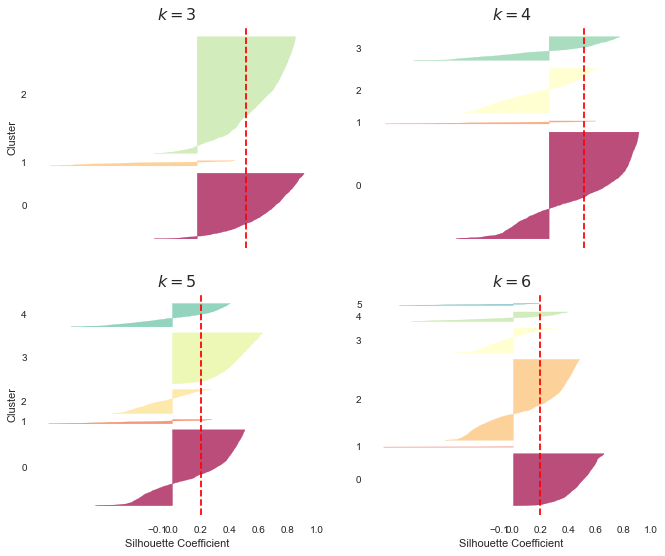

In [74]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = bgm_per_k[k - 1].predict(df_scaled)
    silhouette_coefficients = silhouette_samples(df_scaled, y_pred)

    padding = len(df_rfm) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.savefig("silhouette_analysis_plot")
plt.show()

In [75]:
df_bgm = df_rfm.copy()

In [76]:
bgm = BayesianGaussianMixture(n_components = 4, n_init = 10, random_state = 42)
bgm.fit(df_scaled)
np.round(bgm.weights_, 2)

array([0.33, 0.03, 0.49, 0.16])

In [77]:
df_bgm['cluster'] = bgm.predict(df_scaled)

df_bgm.groupby('cluster').agg({'Recency': 'mean',
                               'Frequency': 'mean',
                               'Monetary': ['mean', 'count']}).round(2)

bgm_agg = df_bgm.groupby('cluster').agg({'Recency': 'mean',
                                         'Frequency': 'mean',
                                         'Monetary': ['mean', 'count']}).round(0)

bgm_agg.columns = bgm_agg.columns.droplevel()
bgm_agg.columns = ['mean_recent', 'mean_freq', 'mean_money', 'count']
bgm_agg['percentage'] = round((bgm_agg['count'] / bgm_agg['count'].sum()) * 100, 2)
bgm_agg = bgm_agg.reset_index()
bgm_agg['cluster'] = 'cluster' + bgm_agg['cluster'].astype(str)

bgm_agg

cluster  mean_recent  mean_freq  mean_money  count  percentage
0  cluster0         33.0        5.0      1469.0   1292       29.78
1  cluster1         23.0       33.0     34518.0    104        2.40
2  cluster2        158.0        1.0       392.0   2298       52.96
3  cluster3         76.0        9.0      3874.0    645       14.87

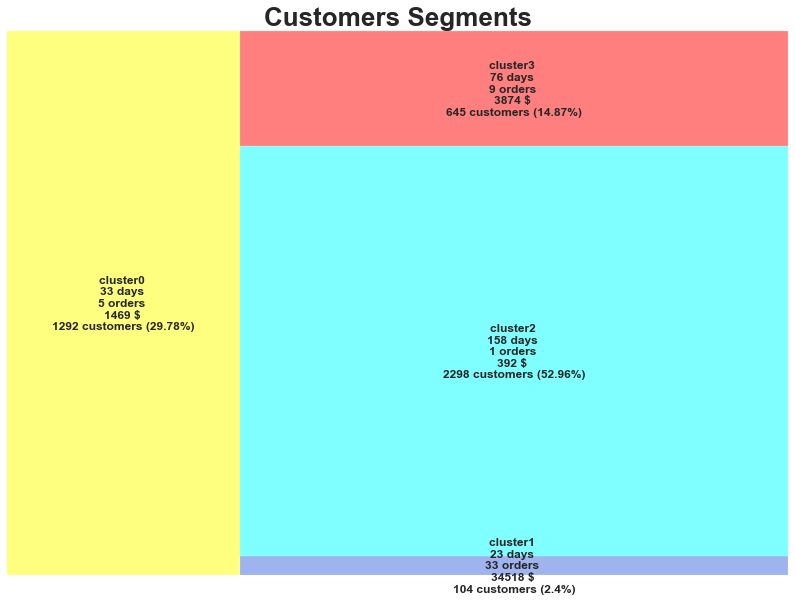

In [78]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=bgm_agg['count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*bgm_agg.iloc[i])
                      for i in range(0, len(bgm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('BGMM_k4.png')
plt.show()

In [79]:
fig = px.scatter(bgm_agg, x='mean_recent', y='mean_freq', size='mean_money', color="cluster",
           hover_name="cluster", size_max=100)
fig.show()

## 4.5 Hierarchy Clustering

In [80]:
df_hc = df_rfm.copy()

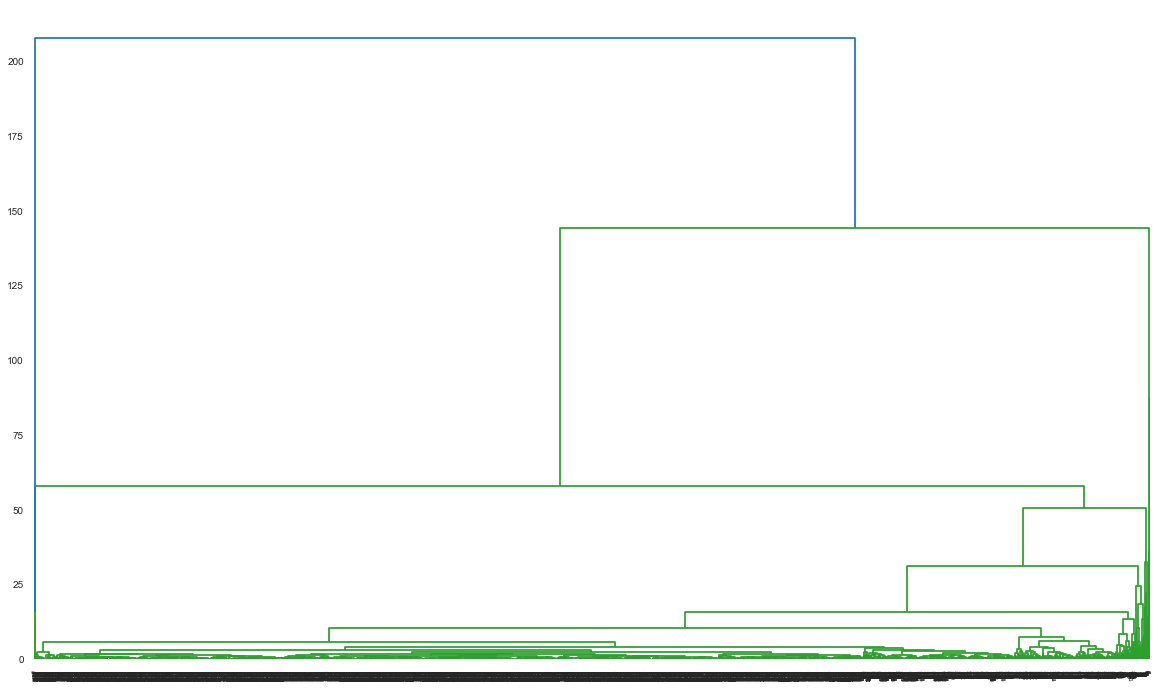

In [81]:
plt.figure(figsize=(20, 12))

mergings = linkage(df_scaled, method='complete', metric='euclidean')
dendrogram(mergings)
plt.show()

In [82]:
cluster_labels = cut_tree(mergings, n_clusters=2).reshape(-1, )
cluster_labels

array([0, 0, 1, ..., 1, 1, 1])

In [83]:
df_hc["cluster"] = cluster_labels

df_hc.groupby('cluster').agg({'Recency': 'mean',
                               'Frequency': 'mean',
                               'Monetary': ['mean', 'count']}).round(2)

hc_agg = df_hc.groupby('cluster').agg({'Recency': 'mean',
                                         'Frequency': 'mean',
                                         'Monetary': ['mean', 'count']}).round(0)

hc_agg.columns = hc_agg.columns.droplevel()
hc_agg.columns = ['mean_recent', 'mean_freq', 'mean_money', 'count']
hc_agg['percentage'] = round((hc_agg['count'] / hc_agg['count'].sum()) * 100, 2)
hc_agg = hc_agg.reset_index()
hc_agg['cluster'] = 'cluster' + hc_agg['cluster'].astype(str)

hc_agg

cluster  mean_recent  mean_freq  mean_money  count  percentage
0  cluster0          7.0       67.0    269932.0      2        0.05
1  cluster1        106.0        4.0      1925.0   4337       99.95

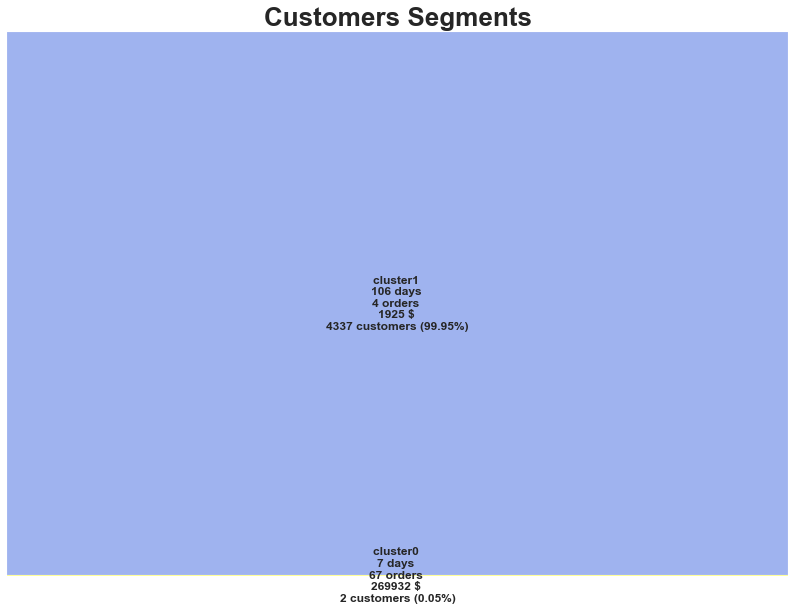

In [84]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=hc_agg['count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*hc_agg.iloc[i])
                      for i in range(0, len(hc_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [85]:
fig = px.scatter(hc_agg, x='mean_recent', y='mean_freq', size='mean_money', color="cluster",
           hover_name="cluster", size_max=100)
fig.show()

## 4.6 DBSCAN

In [86]:
df_db = df_rfm.copy()

In [87]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)
distances = np.sort(distances, axis=0)

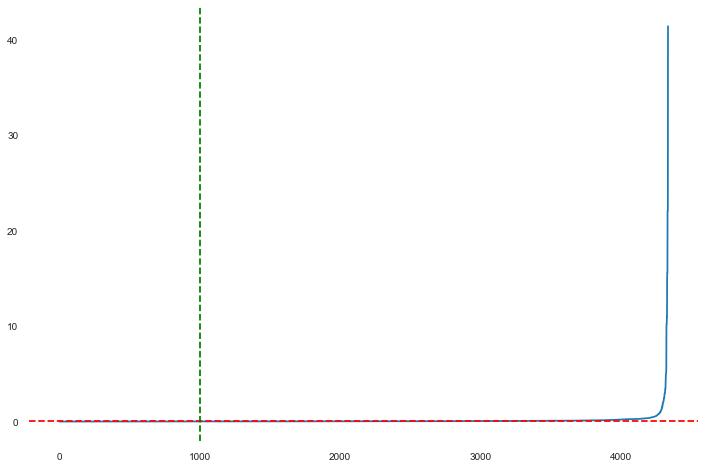

In [88]:
plt.figure(figsize=(12,8))
distances_draw = distances[:,1]
plt.plot(distances_draw)
plt.axhline(y=0.03, color='r', linestyle='--')
plt.axvline(x=1000, color='g', linestyle='--');

In [89]:
dbscan_model = DBSCAN(eps = 0.03, min_samples = 100)
dbscan_model.fit(df_scaled)

DBSCAN(eps=0.03, min_samples=100)

In [90]:
unique(dbscan_model.labels_)

array([-1])

In [91]:
dbscan_res = dbscan_model.fit_predict(df_scaled)
collections.Counter(dbscan_res)
dbscan_res[100:200]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [92]:
df_db["Cluster"] = dbscan_res
df_db.head()

Recency  Frequency   Monetary  Cluster
CustomerID                                        
14646.0           2         74  280206.02       -1
18102.0          12         60  259657.30       -1
17450.0           3         46  194390.79       -1
16446.0          89          2  168472.50       -1
14911.0           0        201  143711.17       -1

In [93]:
df_db.groupby('Cluster').agg({'Recency': 'mean',
                               'Frequency': 'mean',
                               'Monetary': ['mean', 'count']}).round(2)

db_agg = df_db.groupby('Cluster').agg({'Recency': 'mean',
                                         'Frequency': 'mean',
                                         'Monetary': ['mean', 'count']}).round(0)

db_agg.columns = db_agg.columns.droplevel()
db_agg.columns = ['mean_recent', 'mean_freq', 'mean_money', 'count']
db_agg['percentage'] = round((db_agg['count'] / db_agg['count'].sum()) * 100, 2)
db_agg = db_agg.reset_index()
db_agg['Cluster'] = 'Cluster' + db_agg['Cluster'].astype(str)

db_agg

Cluster  mean_recent  mean_freq  mean_money  count  percentage
0  Cluster-1        105.0        4.0      2048.0   4339       100.0

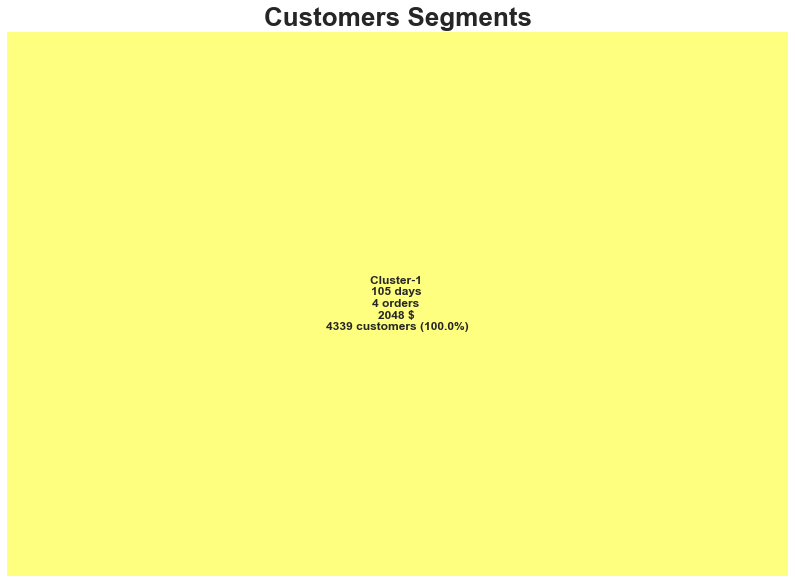

In [94]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=db_agg['count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*db_agg.iloc[i])
                      for i in range(0, len(db_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [95]:
fig = px.scatter(db_agg, x='mean_recent', y='mean_freq', size='mean_money', color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

# 5. Clustering without outliers data

In [96]:
df1 = df_rfm.copy()
df1

Recency  Frequency   Monetary
CustomerID                               
14646.0           2         74  280206.02
18102.0          12         60  259657.30
17450.0           3         46  194390.79
16446.0          89          2  168472.50
14911.0           0        201  143711.17
...             ...        ...        ...
17956.0         250          1      12.75
16454.0          45          2       6.90
14792.0         153          1       6.20
16738.0         298          1       3.75
13256.0          15          1       0.00

[4339 rows x 3 columns]

In [97]:
max_m = df_rfm['Monetary'].mean() + (3*df_rfm['Monetary'].std())
max_f = df_rfm['Frequency'].mean() + (3*df_rfm['Frequency'].std())
max_r = df_rfm['Recency'].mean() + (3*df_rfm['Recency'].std())

high_spenders = df_rfm[df_rfm['Monetary'] >= max_m]
active_spenders = df_rfm[(df_rfm['Frequency'] >= max_f) & (df_rfm['Monetary'] >= df_rfm['Monetary'].mean())]

df_clean = df_rfm[(df_rfm['Monetary'] < max_m)]                   
df_clean = df_clean[(df_clean['Frequency'] < max_f)]
df_clean = df_clean[(df_clean['Recency'] < max_r)]

In [98]:
elite = pd.concat([high_spenders, active_spenders])
elite.shape

(83, 3)

In [99]:
df_clean

Recency  Frequency  Monetary
CustomerID                              
14680.0          26         16  28754.11
13081.0          12         11  28337.38
17857.0          18         23  26879.04
16333.0         124         22  26626.80
12753.0          23          6  21429.39
...             ...        ...       ...
17956.0         250          1     12.75
16454.0          45          2      6.90
14792.0         153          1      6.20
16738.0         298          1      3.75
13256.0          15          1      0.00

[4202 rows x 3 columns]

In [100]:
elite.describe()

Recency   Frequency       Monetary
count   83.000000   83.000000      83.000000
mean    24.084337   51.481928   57453.334578
std     80.683242   42.451224   63628.208229
min      0.000000    1.000000    4124.690000
25%      2.500000   30.000000   16907.355000
50%      9.000000   38.000000   37130.600000
75%     17.000000   56.000000   65039.620000
max    666.000000  210.000000  280206.020000

In [101]:
df_new = df_clean.copy()

In [102]:
df_new.describe()

Recency    Frequency      Monetary
count  4202.000000  4202.000000   4202.000000
mean     98.134698     3.712994   1402.684446
std      95.349028     3.931388   2161.426784
min       0.000000     1.000000      0.000000
25%      22.000000     1.000000    307.810000
50%      60.000000     2.000000    670.135000
75%     156.000000     5.000000   1611.230000
max     424.000000    27.000000  28754.110000

In [103]:
scaler = MinMaxScaler()
df_new_scaled = scaler.fit_transform(df_new)

## 5.1 KMeans

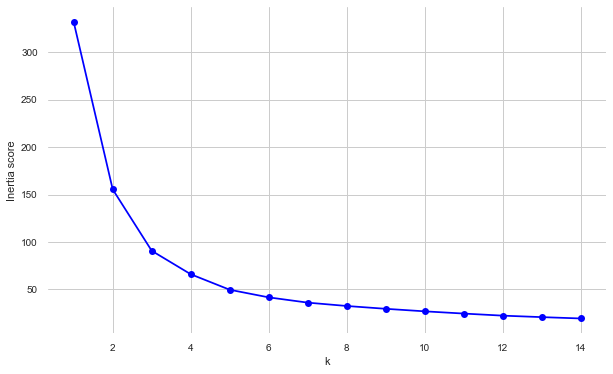

In [104]:
kmeans_per_k = [KMeans(n_clusters = k, random_state = 42).fit(df_new_scaled) for k in range(1, 15)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), inertias, '-bo')
plt.xlabel('k')
plt.ylabel('Inertia score')
plt.grid(True);

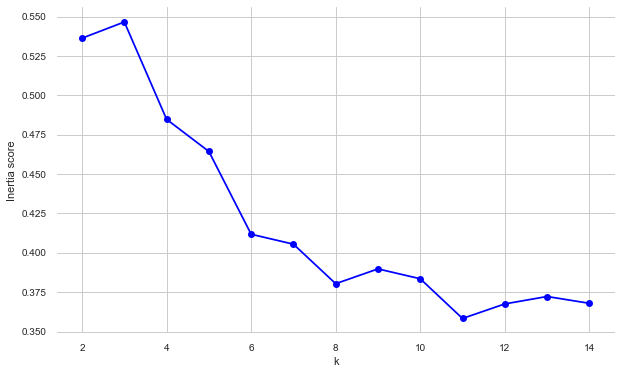

In [105]:
silhouette_scores = [silhouette_score(df_new_scaled, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), silhouette_scores, '-bo')
plt.xlabel('k')
plt.ylabel('Inertia score')
plt.grid(True);

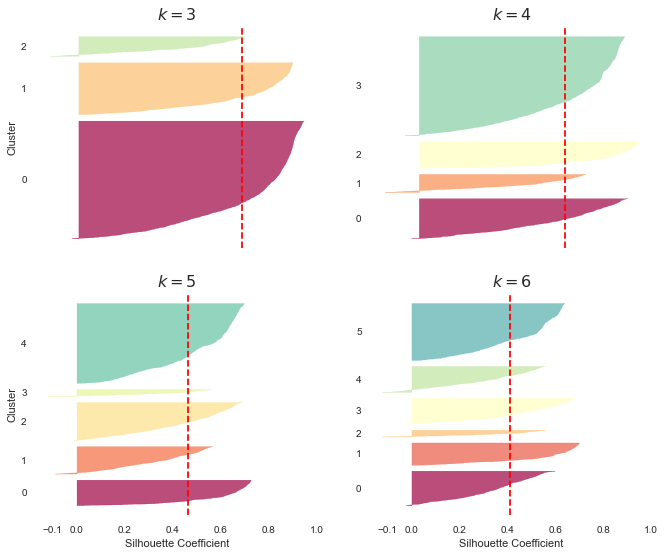

In [106]:
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(df_new_scaled, y_pred)

    padding = len(df_rfm) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.savefig("silhouette_analysis_plot")
plt.show()

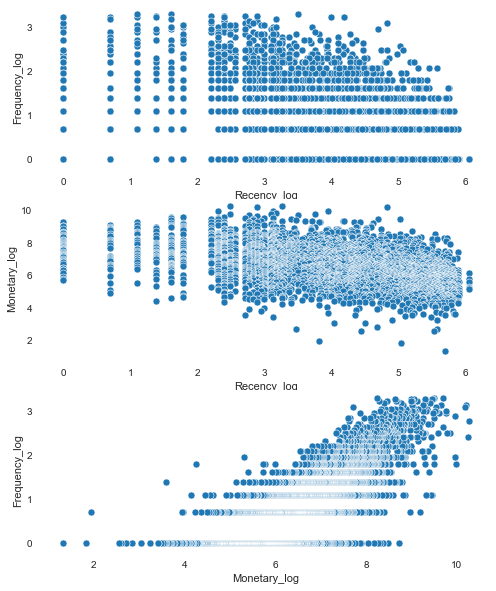

In [107]:
demo = df_new.copy()
for col in demo.columns:
    demo[col + '_log'] = np.log(demo[col])
    
plt.figure(figsize=(8,10))
plt.subplot(3, 1, 1)
sb.scatterplot(data = demo, x = 'Recency_log', y = 'Frequency_log')
plt.subplot(3, 1, 2)
sb.scatterplot(data = demo, x = 'Recency_log', y = 'Monetary_log');
plt.subplot(3, 1, 3)
sb.scatterplot(data = demo, x = 'Monetary_log', y = 'Frequency_log');
plt.show()

In [108]:
df1_kmean = df_new.copy()
df1_kmean.head()

kmean_model = KMeans(n_clusters = 4, random_state = 42)
kmean_model.fit(df_new_scaled)
kmean_model.labels_.shape


df1_kmean['cluster'] = kmean_model.labels_

df1_kmean.groupby('cluster').agg({'Recency': 'mean',
                               'Frequency': 'mean',
                               'Monetary': ['mean', 'count']}).round(2)

kmean_agg1 = df1_kmean.groupby('cluster').agg({'Recency': 'mean',
                                           'Frequency': 'mean',
                                           'Monetary': ['mean', 'count']}).round(0)

kmean_agg1.columns = kmean_agg1.columns.droplevel()
kmean_agg1.columns = ['mean_recent', 'mean_freq', 'mean_money', 'count']
kmean_agg1['percentage'] = round((kmean_agg1['count'] / kmean_agg1['count'].sum()) * 100, 2)
kmean_agg1 = kmean_agg1.reset_index()
kmean_agg1['cluster'] = 'cluster' + kmean_agg1['cluster'].astype(str)
kmean_agg1

cluster  mean_recent  mean_freq  mean_money  count  percentage
0  cluster0        155.0        2.0       715.0    919       21.87
1  cluster1         24.0       13.0      5614.0    414        9.85
2  cluster2        284.0        1.0       437.0    604       14.37
3  cluster3         39.0        3.0      1169.0   2265       53.90

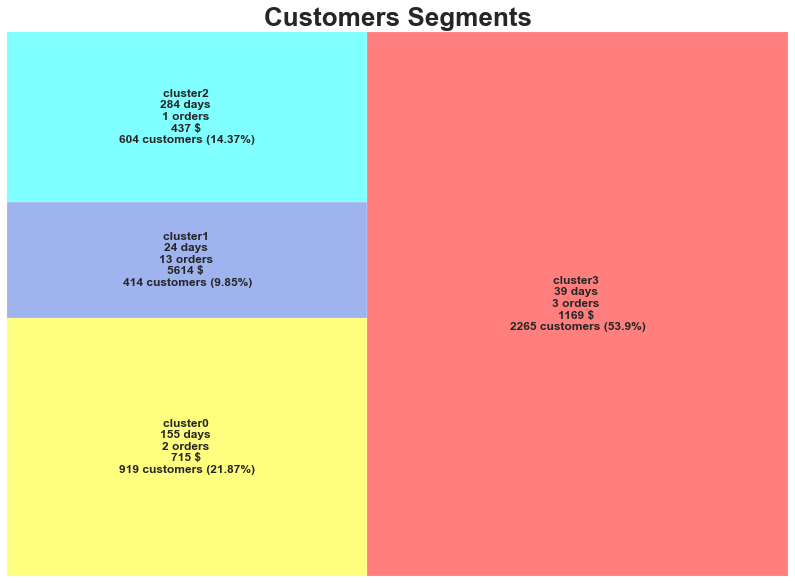

In [109]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=kmean_agg1['count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*kmean_agg1.iloc[i])
                      for i in range(0, len(kmean_agg1))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

# plt.savefig('Unsupervised Segments.png')
plt.show()

In [110]:
fig = px.scatter(kmean_agg1, x='mean_recent', y='mean_freq', size='mean_money', color="cluster",
           hover_name="cluster", size_max=100)
fig.show()

## 5.2 Gaussian Mixture

In [111]:
df_gm1 = df_new.copy()
df_gm1.head()

Recency  Frequency  Monetary
CustomerID                              
14680.0          26         16  28754.11
13081.0          12         11  28337.38
17857.0          18         23  26879.04
16333.0         124         22  26626.80
12753.0          23          6  21429.39

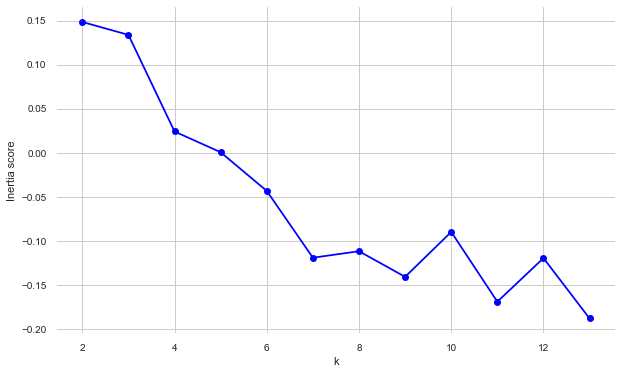

In [112]:
gm_per_k = [GaussianMixture(n_components = k, n_init = 10, random_state = 42).fit(df_new_scaled) for k in range(2, 15)]

silhouette_scores = [silhouette_score(df_new_scaled, model.predict(df_new_scaled)) for model in gm_per_k[1:]]

plt.figure(figsize=(10, 6))
plt.plot(range(2, 14), silhouette_scores, '-bo')
plt.xlabel('k')
plt.ylabel('Inertia score')
plt.grid(True);

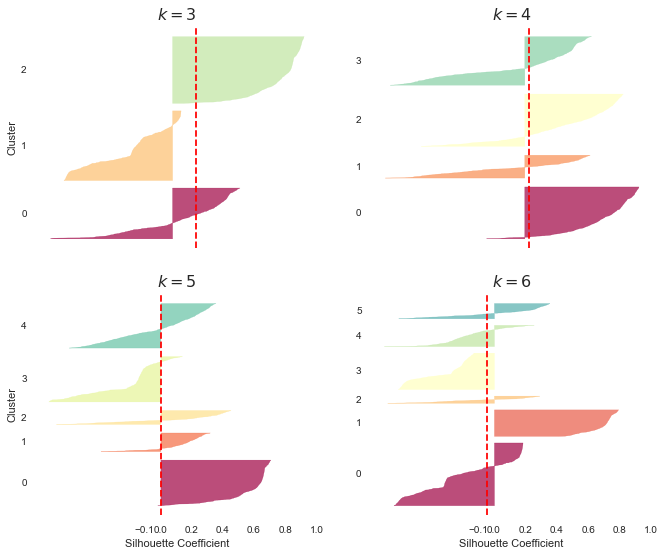

In [113]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = gm_per_k[k - 1].predict(df_new_scaled)
    silhouette_coefficients = silhouette_samples(df_new_scaled, y_pred)

    padding = len(df_rfm) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.savefig("silhouette_analysis_plot")
plt.show()

In [114]:
gm_model = GaussianMixture(n_components = 4, n_init = 10, random_state = 42)
gm_model.fit(df_new_scaled)

GaussianMixture(n_components=4, n_init=10, random_state=42)

In [115]:
gm_cluster1 = gm_model.predict(df_new_scaled)
gm_cluster1

array([3, 3, 3, ..., 1, 1, 1])

In [116]:
df_gm1['cluster'] = gm_cluster1

df_gm1.groupby('cluster').agg({'Recency': 'mean',
                               'Frequency': 'mean',
                               'Monetary': ['mean', 'count']}).round(2)

gm_agg1 = df_gm1.groupby('cluster').agg({'Recency': 'mean',
                                         'Frequency': 'mean',
                                         'Monetary': ['mean', 'count']}).round(0)

gm_agg1.columns = gm_agg1.columns.droplevel()
gm_agg1.columns = ['mean_recent', 'mean_freq', 'mean_money', 'count']
gm_agg1['percentage'] = round((gm_agg1['count'] / gm_agg1['count'].sum()) * 100, 2)
gm_agg1 = gm_agg1.reset_index()
gm_agg1['cluster'] = 'cluster' + gm_agg1['cluster'].astype(str)

gm_agg1

cluster  mean_recent  mean_freq  mean_money  count  percentage
0  cluster0        150.0        3.0       975.0    978       23.27
1  cluster1        157.0        1.0       284.0   1340       31.89
2  cluster2         26.0        4.0      1159.0   1284       30.56
3  cluster3         35.0       11.0      5119.0    600       14.28

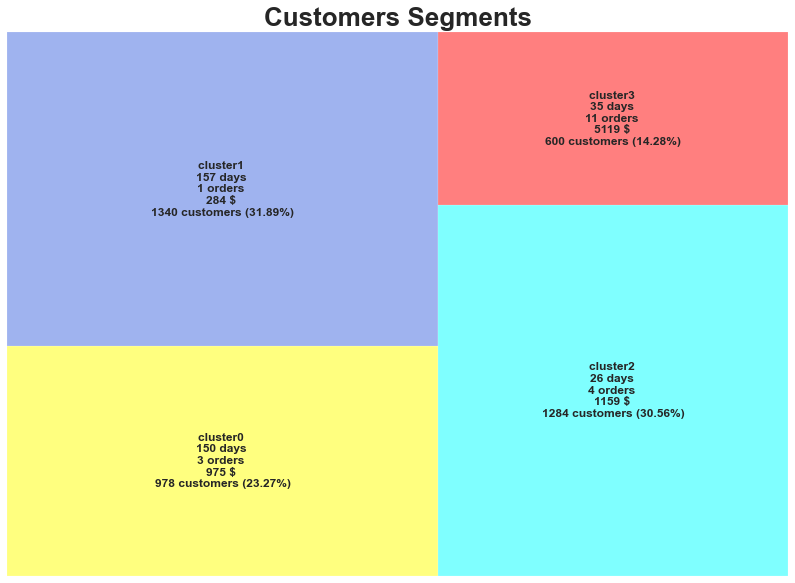

In [117]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=gm_agg1['count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*gm_agg1.iloc[i])
                      for i in range(0, len(gm_agg1))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.savefig('GMM1_k4.png')
plt.show()

In [118]:
fig = px.scatter(gm_agg1, x='mean_recent', y='mean_freq', size='mean_money', color="cluster",
           hover_name="cluster", size_max=100)
fig.show()

## 5.3 Bayesian Gaussian Mixture

In [119]:
df_bgm1 = df_new.copy()
df_bgm1.head()

Recency  Frequency  Monetary
CustomerID                              
14680.0          26         16  28754.11
13081.0          12         11  28337.38
17857.0          18         23  26879.04
16333.0         124         22  26626.80
12753.0          23          6  21429.39

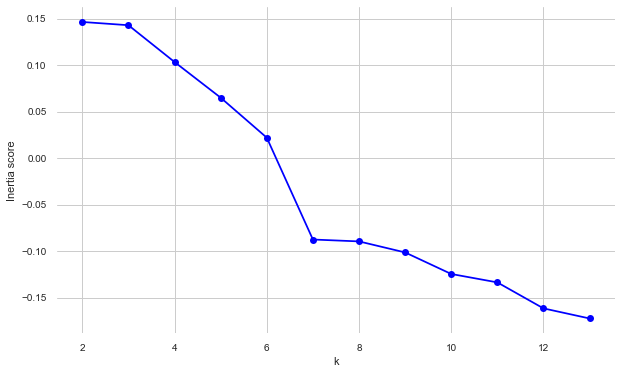

In [120]:
bgm_per_k = [BayesianGaussianMixture(n_components = k, n_init = 10, random_state = 42).fit(df_new_scaled) for k in range(2, 15)]

silhouette_scores = [silhouette_score(df_new_scaled, model.predict(df_new_scaled)) for model in bgm_per_k[1:]]

plt.figure(figsize=(10, 6))
plt.plot(range(2, 14), silhouette_scores, '-bo')
plt.xlabel('k')
plt.ylabel('Inertia score')
plt.grid(True);

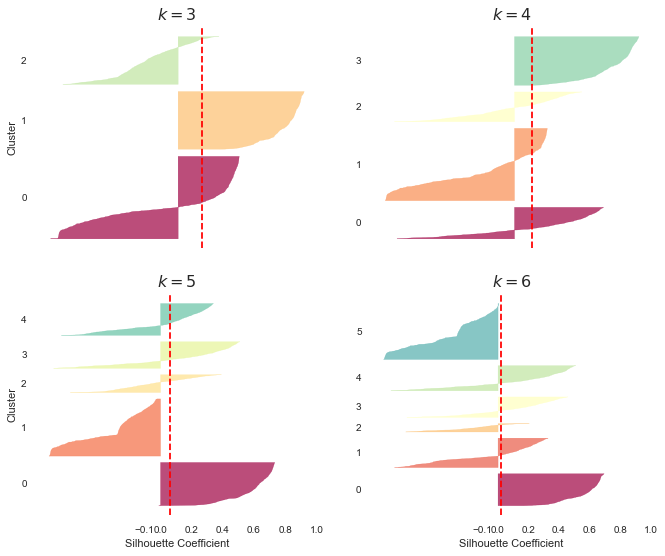

In [121]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = bgm_per_k[k - 1].predict(df_new_scaled)
    silhouette_coefficients = silhouette_samples(df_new_scaled, y_pred)

    padding = len(df_rfm) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.savefig("silhouette_analysis_plot")
plt.show()

In [152]:
bgm_model = BayesianGaussianMixture(n_components = 4, n_init = 10, random_state = 42)
bgm_model.fit(df_new_scaled)
np.round(bgm_model.weights_, 2)

array([0.38, 0.28, 0.23, 0.11])

In [123]:
bgm_cluster1 = bgm_model.predict(df_new_scaled)
bgm_cluster1

array([3, 3, 3, ..., 0, 0, 0])

In [124]:
df_bgm1['cluster'] = bgm_cluster1

df_bgm1.groupby('cluster').agg({'Recency': 'mean',
                               'Frequency': 'mean',
                               'Monetary': ['mean', 'count']}).round(2)

bgm_agg1 = df_bgm1.groupby('cluster').agg({'Recency': 'mean',
                                         'Frequency': 'mean',
                                         'Monetary': ['mean', 'count']}).round(0)

bgm_agg1.columns = bgm_agg1.columns.droplevel()
bgm_agg1.columns = ['mean_recent', 'mean_freq', 'mean_money', 'count']
bgm_agg1['percentage'] = round((bgm_agg1['count'] / bgm_agg1['count'].sum()) * 100, 2)
bgm_agg1 = bgm_agg1.reset_index()
bgm_agg1['cluster'] = 'cluster' + bgm_agg1['cluster'].astype(str)

bgm_agg1

cluster  mean_recent  mean_freq  mean_money  count  percentage
0  cluster0        164.0        1.0       309.0   1658       39.46
1  cluster1         31.0        3.0       900.0   1159       27.58
2  cluster2         99.0        5.0      1865.0    959       22.82
3  cluster3         24.0       13.0      5985.0    426       10.14

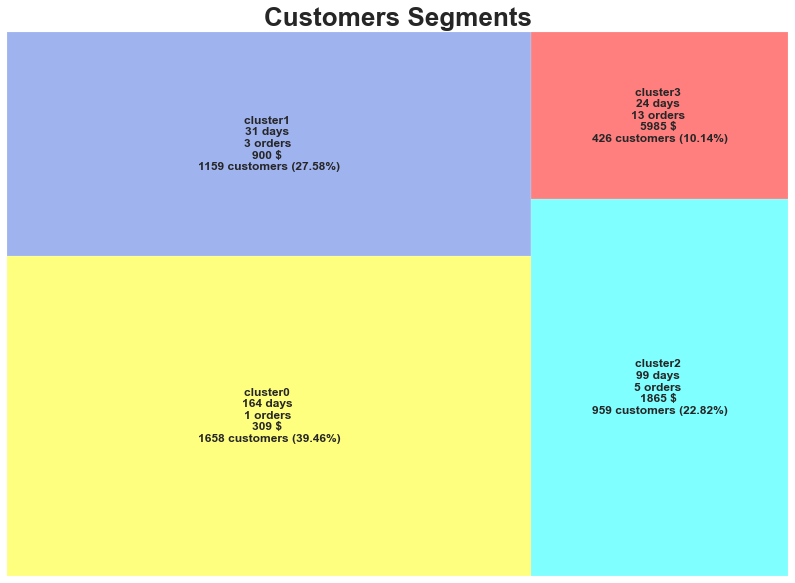

In [125]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=bgm_agg1['count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*bgm_agg1.iloc[i])
                      for i in range(0, len(bgm_agg1))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.savefig('BGMM1_k4.png')
plt.show()

In [126]:
fig = px.scatter(bgm_agg1, x='mean_recent', y='mean_freq', size='mean_money', color="cluster",
           hover_name="cluster", size_max=100)
fig.show()

## 5.4 Hierarchy Clustering

In [127]:
df_hc1 = df_new.copy()

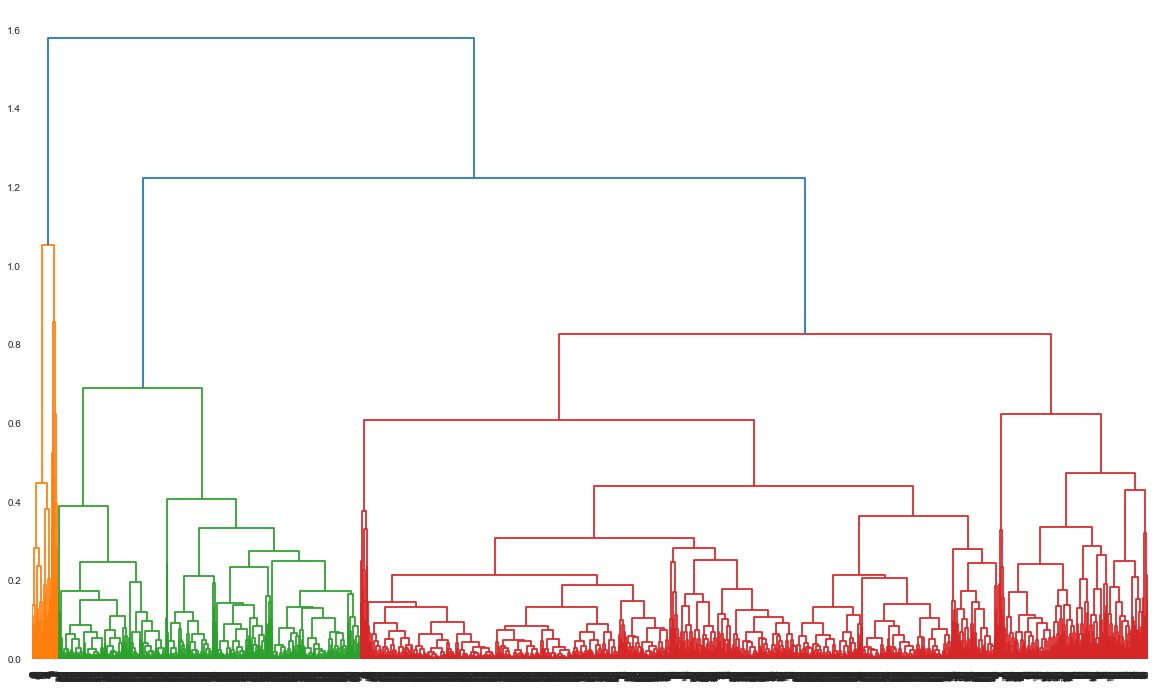

In [128]:
plt.figure(figsize=(20, 12))

mergings = linkage(df_new_scaled, method='complete', metric='euclidean')
dendrogram(mergings)
plt.show()

In [129]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 2, 2, 1])

In [130]:
df_hc1["cluster"] = cluster_labels

df_hc1.groupby('cluster').agg({'Recency': 'mean',
                               'Frequency': 'mean',
                               'Monetary': ['mean', 'count']}).round(2)

hc_agg1 = df_hc1.groupby('cluster').agg({'Recency': 'mean',
                                         'Frequency': 'mean',
                                         'Monetary': ['mean', 'count']}).round(0)

hc_agg1.columns = hc_agg1.columns.droplevel()
hc_agg1.columns = ['mean_recent', 'mean_freq', 'mean_money', 'count']
hc_agg1['percentage'] = round((hc_agg1['count'] / hc_agg1['count'].sum()) * 100, 2)
hc_agg1 = hc_agg1.reset_index()
hc_agg1['cluster'] = 'cluster' + hc_agg1['cluster'].astype(str)

hc_agg1

cluster  mean_recent  mean_freq  mean_money  count  percentage
0  cluster0         16.0       20.0      9056.0    101        2.40
1  cluster1         48.0        4.0      1477.0   2963       70.51
2  cluster2        236.0        2.0       531.0   1138       27.08

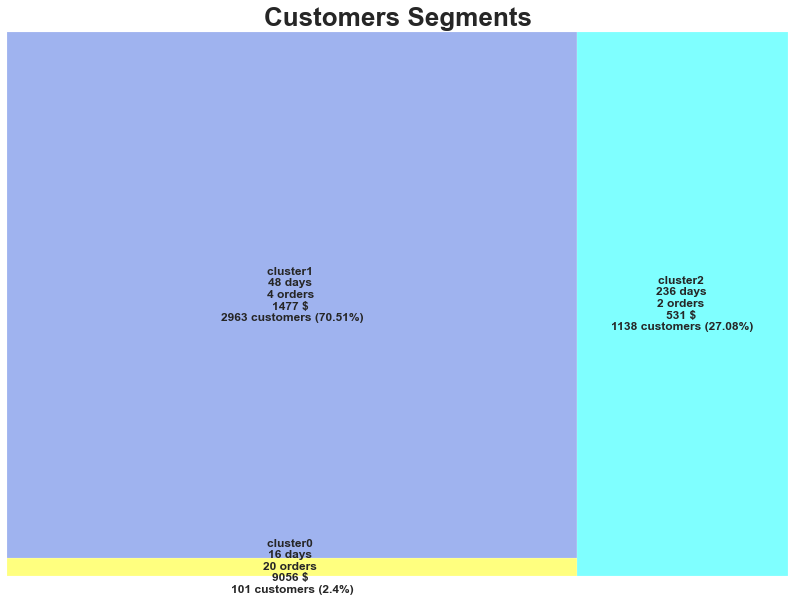

In [131]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=hc_agg1['count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*hc_agg1.iloc[i])
                      for i in range(0, len(hc_agg1))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [132]:
fig = px.scatter(hc_agg1, x='mean_recent', y='mean_freq', size='mean_money', color="cluster",
           hover_name="cluster", size_max=100)
fig.show()

## 5.5 DBSCAN

In [133]:
df_db1 = df_new.copy()

In [134]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(df_new_scaled)
distances, indices = neighbors_fit.kneighbors(df_new_scaled)
distances = np.sort(distances, axis=0)

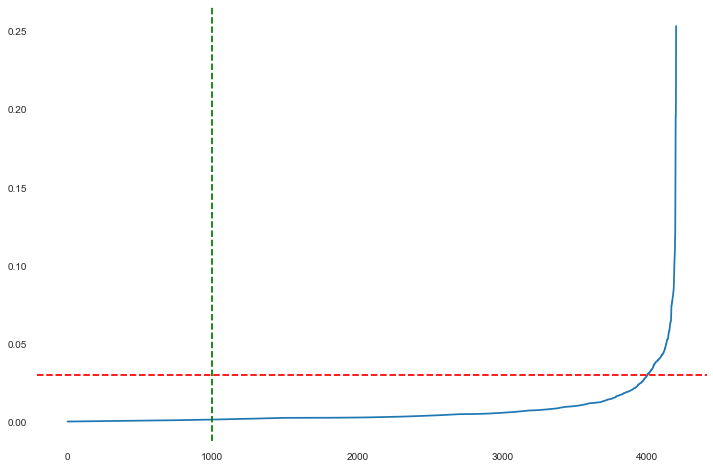

In [135]:
plt.figure(figsize=(12,8))
distances_draw = distances[:,1]
plt.plot(distances_draw)
plt.axhline(y=0.03, color='r', linestyle='--')
plt.axvline(x=1000, color='g', linestyle='--');

In [136]:
dbscan_model = DBSCAN(eps = 0.03, min_samples = 100)
dbscan_model.fit(df_new_scaled)

DBSCAN(eps=0.03, min_samples=100)

In [137]:
unique(dbscan_model.labels_)

array([-1,  0,  1,  2,  3,  4,  5])

In [138]:
dbscan_res = dbscan_model.fit_predict(df_new_scaled)
collections.Counter(dbscan_res)
dbscan_res[100:200]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [139]:
df_db1["cluster"] = dbscan_res

df_db1.groupby('cluster').agg({'Recency': 'mean',
                               'Frequency': 'mean',
                               'Monetary': ['mean', 'count']}).round(2)

db_agg1 = df_db1.groupby('cluster').agg({'Recency': 'mean',
                                         'Frequency': 'mean',
                                         'Monetary': ['mean', 'count']}).round(0)

db_agg1.columns = db_agg1.columns.droplevel()
db_agg1.columns = ['mean_recent', 'mean_freq', 'mean_money', 'count']
db_agg1['percentage'] = round((db_agg1['count'] / db_agg1['count'].sum()) * 100, 2)
db_agg1 = db_agg1.reset_index()
db_agg1['cluster'] = 'cluster' + db_agg1['cluster'].astype(str)

db_agg1

cluster  mean_recent  mean_freq  mean_money  count  percentage
0  cluster-1        117.0        5.0      1874.0   2728       64.92
1   cluster0         15.0        4.0      1105.0    158        3.76
2   cluster1         20.0        3.0       890.0    181        4.31
3   cluster2         26.0        2.0       576.0    322        7.66
4   cluster3         49.0        1.0       339.0    573       13.64
5   cluster4        177.0        1.0       255.0    136        3.24
6   cluster5        270.0        1.0       307.0    104        2.48

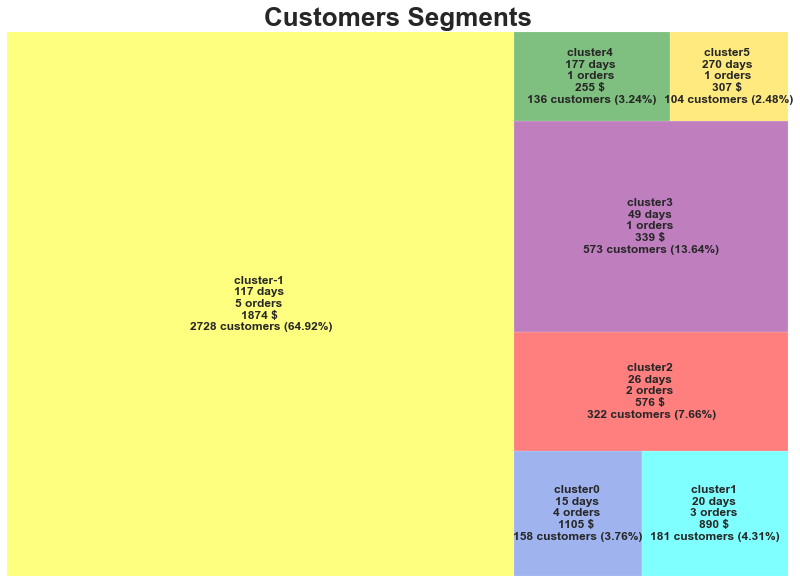

In [140]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=db_agg1['count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*db_agg1.iloc[i])
                      for i in range(0, len(db_agg1))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [141]:
fig = px.scatter(db_agg1, x='mean_recent', y='mean_freq', size='mean_money', color="cluster",
           hover_name="cluster", size_max=100)
fig.show()